In [1]:
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

import matplotlib.pyplot as plt
%matplotlib inline

# Load MNIST data
import mnist

In [2]:
def xavier_init(channel_in, channel_out, constant = 1): 
    """
    Xavier initialization of network weights
    """
    
    low = -constant * np.sqrt(6.0 / (channel_in + channel_out)) 
    high = constant * np.sqrt(6.0 / (channel_in + channel_out))
    return tf.random_uniform((channel_in, channel_out), minval = low, maxval = high, dtype=tf.float32)

In [10]:
def BCE(x, y):
    """
    Calculate binary cross entropy loss for reconstruction loss in the ELBO.
    """

    loss = np.sum(-y * np.log(x + 10e-8) - (1 - y) * np.log(1 - x + 10e-8))

    return loss

In [14]:
class VAE(object):
    
    def __init__(self, network_architecture, learning_rate=0.001, batch_size=100):
        """
        Set up the VAE model.
        """
        
        # Set model parameters
        self.network_architecture = network_architecture
        self.lr = learning_rate
        self.batch_size = batch_size
        
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Forward pass
        self.forward()
        
        # Backward pass
        self.backward()

        # Initialize the variables and launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        
    def initialize_weights(self, n_hidden_enc_1, n_hidden_enc_2, 
                           n_hidden_dec_1, n_hidden_dec_2, n_input, n_z):
        """
        Initialize weights of the network layers.
        """
        
        network_weights = dict()
        network_weights['encoder_weights'] = {
            'W1': tf.Variable(xavier_init(n_input, n_hidden_enc_1)),
            'W2': tf.Variable(xavier_init(n_hidden_enc_1, n_hidden_enc_2)),
            'W_mu': tf.Variable(xavier_init(n_hidden_enc_2, n_z)),
            'W_logvar': tf.Variable(xavier_init(n_hidden_enc_2, n_z))}
        network_weights['encoder_bias'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_enc_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_enc_2], dtype=tf.float32)),
            'b_mu': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'b_logvar': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        network_weights['decoder_weights'] = {
            'W1': tf.Variable(xavier_init(n_z, n_hidden_dec_1)),
            'W2': tf.Variable(xavier_init(n_hidden_dec_1, n_hidden_dec_2)),
            'W_out': tf.Variable(xavier_init(n_hidden_dec_2, n_input))}
        network_weights['decoder_bias'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_dec_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_dec_2], dtype=tf.float32)),
            'b_out': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return network_weights
 

    def encode(self, weights, bias):
        """
        Use the encoder model to map the input data to the latent space.
        """
        
        hidden_1 = tf.nn.relu(tf.add(tf.matmul(self.x, weights['W1']), bias['b1'])) 
        hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, weights['W2']), bias['b2'])) 
        mu = tf.add(tf.matmul(hidden_2, weights['W_mu']), bias['b_mu'])
        logvar = tf.add(tf.matmul(hidden_2, weights['W_logvar']), bias['b_logvar'])
        return (mu, logvar)

    def decode(self, weights, bias):
        """
        Use the decoder model to reconstruct the input data.
        """
        
        hidden_1 = tf.nn.leaky_relu(tf.add(tf.matmul(self.z, weights['W1']), bias['b1'])) 
        hidden_2 = tf.nn.leaky_relu(tf.add(tf.matmul(hidden_1, weights['W2']), bias['b2'])) 
        recon_x = tf.nn.sigmoid(tf.add(tf.matmul(hidden_2, weights['W_out']), bias['b_out']))
        return recon_x
    
    
    def forward(self):
        """
        Build the VAE network.
        """
        
        # Initialize weights and bias
        network_weights = self.initialize_weights(**self.network_architecture)

        # Use encoder model to obtain latent z
        self.mu, self.logvar = self.encode(network_weights["encoder_weights"], 
                                      network_weights["encoder_bias"])

        # Draw sample z from Gaussian using reparametrization trick
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32)
        self.z = tf.add(self.mu, tf.multiply(tf.sqrt(tf.exp(self.logvar)), eps))

        # Use decoder model to obtain the reconstructed input
        self.recon_x = self.decode(network_weights["decoder_weights"],
                                    network_weights["decoder_bias"])
            
            
    def backward(self):
        """
        Calculate gradients using backpropagation and update weights using Adam optimizer.
        """
        
        rec_loss = - tf.reduce_sum(self.x * tf.log(1e-8 + self.recon_x)
                           + (1 - self.x) * tf.log(1e-8 + 1 - self.recon_x), 1)
      
        kl = -0.5 * tf.reduce_sum(1 + self.logvar - tf.square(self.mu) - tf.exp(self.logvar), 1)
        
        self.loss = tf.reduce_mean(rec_loss + kl)   
       
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.lr).minimize(self.loss)
        
    def train(self, X):
        """
        Train model based on mini-batch of input data.
        Return loss of mini-batch.
        """
        
        opt, loss = self.sess.run((self.optimizer, self.loss), 
                                                feed_dict={self.x: X})
        return loss
    
    def evaluate(self, X, recon_X):
        """
        Evaluate the accuracy of the model with reconstruction error and marginal log-likelihood.
        """
        rec_loss = BCE(recon_X, X) / len(X)
        # Marginal log-likelihood of data = - ELBO
        marg_likelihood = - self.train(X)
        
        return rec_loss, marg_likelihood
    
    def transform(self, X):
        """
        Transform data by mapping it into the latent space.
        """
        # Note: This maps to mean of distribution, we could alternatively sample from Gaussian distribution
        return self.sess.run((self.mu, self.logvar), feed_dict={self.x: X})
    
    def transform1d(self, X):
        """
        Transform data by mapping it into the latent space.
        """
        # Note: This maps to mean of distribution, we could alternatively sample from Gaussian distribution
        return self.sess.run(self.mu, feed_dict={self.x: X})
    
    def generate(self, mu = None):
        """ 
        Generate data by sampling from the latent space.        
        """
        if mu is None:
            # Data is alternatively generated from the prior in the latent space
            mu = np.random.normal(size = self.network_architecture["n_z"])

        return self.sess.run(self.recon_x, feed_dict={self.z: mu})
    
    def reconstruct(self, X):
        """ 
        Reconstruct the given input data. 
        """
        
        return self.sess.run(self.recon_x, feed_dict={self.x: X})

In [15]:
def train_mnist(network_architecture, images,
                learning_rate=0.001, batch_size=100, n_epoch=10):
    """
    Train the VAE model on the MNIST data set.
    """
    
    vae = VAE(network_architecture, learning_rate=learning_rate, batch_size=batch_size)
    
    #images = mnist.train_images() 
    train_size = len(images)
    train_data = images.reshape((train_size, 784)) / 255 # normalize to [0,1]
    
    for epoch in range(n_epoch):
        
        avg_loss = 0.
        n_batch = int(train_size / batch_size) 

        for idx in range(n_batch):
            train_batch = train_data[idx * batch_size:idx * batch_size + batch_size]
            loss = vae.train(train_batch)
            avg_loss += loss / train_size * batch_size

        print("Epoch:", "%d/%d" % (epoch+1, n_epoch), 
              "Loss =", "{:.4f}".format(avg_loss))
        
    return vae

In [70]:
def test_mnist(model, images, batch_size=100):
    """
    Test the trained VAE model of the MNIST data set.
    """
        
    #images = mnist.test_images() 
    test_size = len(images)
    test_data = images.reshape((test_size, 784)) / 255 # normalize to [0,1]
    
    avg_rec_loss = 0
    avg_marg_likelihood = 0
    n_batch = int(test_size / batch_size)
    
    for idx in range(n_batch):
        test_batch = test_data[idx * batch_size:idx * batch_size + batch_size]
        recon_test = model.reconstruct(test_batch)
        rec_loss, marg_likelihood = model.evaluate(test_batch, recon_test)
        avg_rec_loss += rec_loss
        avg_marg_likelihood += marg_likelihood
    avg_rec_loss /= n_batch
    avg_marg_likelihood /= n_batch

    print("Test recon loss =", "{:.4f}".format(avg_rec_loss),
         "Marginal likelihood =", "{:.4f}".format(avg_marg_likelihood))
        
    return - avg_marg_likelihood

In [ ]:
sample_size = [int(x) for x in np.arange(5000, 60000, 5000)]
sample_size.append(60000)

In [94]:
network_architecture = dict(n_hidden_enc_1 = 500, 
                             n_hidden_enc_2 = 500, 
                             n_hidden_dec_1 = 500, 
                             n_hidden_dec_2 = 500, 
                             n_input = 784, 
                             n_z = 5)  

vae = train_mnist(network_architecture, mnist.train_images()[:sample_size[11],], n_epoch = 50)

Epoch: 1/50 Loss = 163.0895
Epoch: 2/50 Loss = 135.8857
Epoch: 3/50 Loss = 131.4322
Epoch: 4/50 Loss = 128.8604
Epoch: 5/50 Loss = 126.9896
Epoch: 6/50 Loss = 125.4114
Epoch: 7/50 Loss = 124.1989
Epoch: 8/50 Loss = 123.0698
Epoch: 9/50 Loss = 122.1170
Epoch: 10/50 Loss = 121.3882
Epoch: 11/50 Loss = 120.6320
Epoch: 12/50 Loss = 120.0001
Epoch: 13/50 Loss = 119.4828
Epoch: 14/50 Loss = 118.9575
Epoch: 15/50 Loss = 118.4687
Epoch: 16/50 Loss = 117.9989
Epoch: 17/50 Loss = 117.6058
Epoch: 18/50 Loss = 117.2170
Epoch: 19/50 Loss = 116.9051
Epoch: 20/50 Loss = 116.5913
Epoch: 21/50 Loss = 116.2919
Epoch: 22/50 Loss = 116.0236
Epoch: 23/50 Loss = 115.7398
Epoch: 24/50 Loss = 115.5105
Epoch: 25/50 Loss = 115.2340
Epoch: 26/50 Loss = 115.0571
Epoch: 27/50 Loss = 114.8293
Epoch: 28/50 Loss = 114.6961
Epoch: 29/50 Loss = 114.4998
Epoch: 30/50 Loss = 114.3578
Epoch: 31/50 Loss = 114.1587
Epoch: 32/50 Loss = 114.0077
Epoch: 33/50 Loss = 113.8787
Epoch: 34/50 Loss = 113.7014
Epoch: 35/50 Loss = 113

In [96]:
test_mnist(vae, mnist.test_images())

Test recon loss = 103.9014 Marginal likelihood = -116.3102


116.31024230957031

In [103]:
# dim_z = 5, epochs = 50
train_elbo_5 = [-121.2997, -118.2727, -116.8740, -115.3436, -114.5897, -114.1801, -113.7534, -112.9833, -112.3751, -112.6949, -112.5176, -112.0410]
test_elbo_5 = [-128.9256, -124.3725, -122.1839, -120.3428, -119.9257, -119.2636, -118.4749, -117.6165, -116.8947, -116.4689, -115.9002, -116.3102]

(-130, -100)

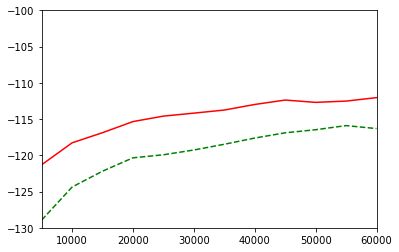

In [114]:
plt.plot(sample_size, train_elbo_5, '-r')
plt.plot(sample_size, test_elbo_5, '--g')
plt.xlim(5000, 60000)
plt.ylim(-130, -100)

In [117]:
# dim_z = 20, epochs = 50
train_elbo_20 = [-106.1172, -102.3876, -100.8903, -99.3322, -98.9384, -98.4139, -98.0962, -98.0979, -97.7198, -97.9278, -97.7350, -97.4193]
test_elbo_20 = [-111.4163, -107.4929, -104.9449, -103.3758, -102.3214, -101.2189, -100.7701, -100.6471, -99.9331, -99.6764, -99.6234, -99.0220]

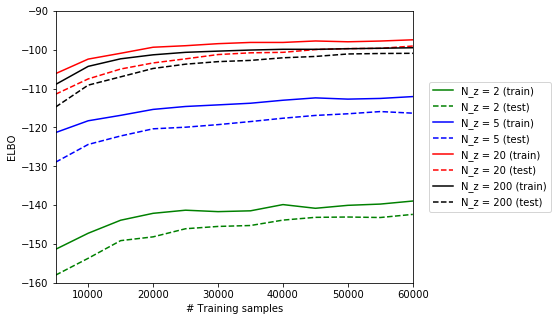

In [170]:
fig = plt.figure(figsize=(8,5))
ax = plt.axes()
ax.plot(sample_size, train_elbo_2, '-g')
ax.plot(sample_size, test_elbo_2, '--g')
ax.plot(sample_size, train_elbo_5, '-b')
ax.plot(sample_size, test_elbo_5, '--b')
ax.plot(sample_size, train_elbo_20, '-r')
ax.plot(sample_size, test_elbo_20, '--r')
ax.plot(sample_size, train_elbo_200, '-k')
ax.plot(sample_size, test_elbo_200, '--k')
ax.set(xlim=(5000, 60000), ylim=(-160, -90),
        ylabel='ELBO', xlabel='# Training samples')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(('N_z = 2 (train)','N_z = 2 (test)', 'N_z = 5 (train)','N_z = 5 (test)','N_z = 20 (train)','N_z = 20 (test)',
          'N_z = 200 (train)','N_z = 200 (test)'), loc='center right', bbox_to_anchor=(1.4, 0.5))
pass

In [135]:
# dim_z = 200, epochs = 50
train_elbo_200 = [-108.9064, -104.2627, -102.3121, -101.2841, -100.6434, -100.3342, -100.0575, -99.8589, -99.8702, -99.7187, -99.5911, -99.4647]
test_elbo_200 = [-114.7176, -109.0942, -106.9578, -104.7997, -103.6941, -103.0400, -102.7230, -102.0488, -101.7043, -101.0675, -100.9446, -100.8956]

In [157]:
# dim_z = 2, epochs = 50
train_elbo_2 = [-151.3631, -147.2380, -143.8847, -142.1062, -141.3018, -141.6726, -141.4615, -139.8585, -140.8098, -140.0482, -139.7241, -138.9407]
test_elbo_2 = [-158.0134, -153.6901, -149.1396, -148.1666, -146.0767, -145.4832, -145.2455, -143.8529, -143.1435, -143.0591, -143.1847, -142.3782]

In [172]:
network_architecture = dict(n_hidden_enc_1=500, 
                             n_hidden_enc_2=500, 
                             n_hidden_dec_1=500, 
                             n_hidden_dec_2=500, 
                             n_input=784, 
                             n_z=2) 

vae_2d = train_mnist(network_architecture, mnist.train_images(), n_epoch = 50)

/Users/yizizhang/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/client/session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 1/50 Loss = 185.9778
Epoch: 2/50 Loss = 165.0139
Epoch: 3/50 Loss = 159.7731
Epoch: 4/50 Loss = 156.6082
Epoch: 5/50 Loss = 154.3158
Epoch: 6/50 Loss = 152.6744
Epoch: 7/50 Loss = 151.2319
Epoch: 8/50 Loss = 150.0464
Epoch: 9/50 Loss = 149.2035
Epoch: 10/50 Loss = 148.3605
Epoch: 11/50 Loss = 147.4336
Epoch: 12/50 Loss = 146.8749
Epoch: 13/50 Loss = 146.4896
Epoch: 14/50 Loss = 145.9358
Epoch: 15/50 Loss = 145.4354
Epoch: 16/50 Loss = 145.1130
Epoch: 17/50 Loss = 144.6014
Epoch: 18/50 Loss = 144.4061
Epoch: 19/50 Loss = 143.9957
Epoch: 20/50 Loss = 143.6816
Epoch: 21/50 Loss = 143.4192
Epoch: 22/50 Loss = 143.0973
Epoch: 23/50 Loss = 142.8696
Epoch: 24/50 Loss = 142.7878
Epoch: 25/50 Loss = 142.4669
Epoch: 26/50 Loss = 142.4250
Epoch: 27/50 Loss = 142.2523
Epoch: 28/50 Loss = 141.9917
Epoch: 29/50 Loss = 141.7853
Epoch: 30/50 Loss = 141.8487
Epoch: 31/50 Loss = 141.6980
Epoch: 32/50 Loss = 141.4193
Epoch: 33/50 Loss = 141.1640
Epoch: 34/50 Loss = 141.0008
Epoch: 35/50 Loss = 141

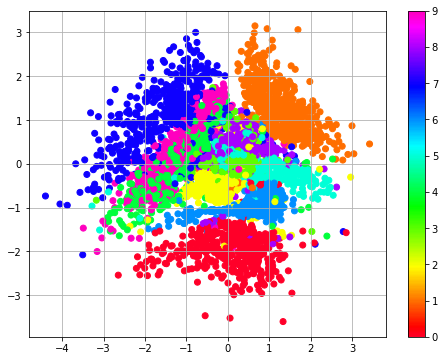

In [196]:
images = mnist.train_images()
labels = mnist.train_labels()
x_sample = (images.reshape((60000, 784)) / 255)[:5000,]
y_sample = labels[:5000]
z_mu = vae_2d.transform1d(x_sample)
cm = plt.cm.get_cmap('gist_rainbow')
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y_sample, cmap=cm)
plt.colorbar()
plt.grid()

In [55]:
x = np.linspace(0, 3, 50)
print(x)

[0.         0.06122449 0.12244898 0.18367347 0.24489796 0.30612245
 0.36734694 0.42857143 0.48979592 0.55102041 0.6122449  0.67346939
 0.73469388 0.79591837 0.85714286 0.91836735 0.97959184 1.04081633
 1.10204082 1.16326531 1.2244898  1.28571429 1.34693878 1.40816327
 1.46938776 1.53061224 1.59183673 1.65306122 1.71428571 1.7755102
 1.83673469 1.89795918 1.95918367 2.02040816 2.08163265 2.14285714
 2.20408163 2.26530612 2.32653061 2.3877551  2.44897959 2.51020408
 2.57142857 2.63265306 2.69387755 2.75510204 2.81632653 2.87755102
 2.93877551 3.        ]


In [35]:
train_elbo_nz20 = np.load('train_elbo.npy') * (-1.)
test_elbo_nz20 = np.load('test_elbo.npy') * (-1.)
test_elbo_nz20 += (np.min(train_elbo_nz20) - np.min(test_elbo_nz20))

In [44]:
train_elbo_nz3 = np.load('train_elbo.npy') * (-1.)
train_elbo_nz3 += (np.min(train_elbo_nz20) - np.min(train_elbo_nz3))
test_elbo_nz3 = np.load('test_elbo.npy') * (-1.)
test_elbo_nz3 += (np.min(train_elbo_nz3) - np.min(test_elbo_nz3))

In [52]:
train_elbo_nz10 = np.load('train_elbo.npy') * (-1.)
train_elbo_nz10 += (np.min(train_elbo_nz20) - np.min(train_elbo_nz10))
test_elbo_nz10 = np.load('test_elbo.npy') * (-1.)
test_elbo_nz10 += (np.min(train_elbo_nz10) - np.min(test_elbo_nz10))

In [72]:
train_elbo_nz200 = np.load('train_elbo.npy') * (-1.)
train_elbo_nz200 += (np.min(train_elbo_nz20) - np.min(train_elbo_nz200))
test_elbo_nz200 = np.load('test_elbo.npy') * (-1.)
test_elbo_nz200 += (np.min(train_elbo_nz200) - np.min(test_elbo_nz200))

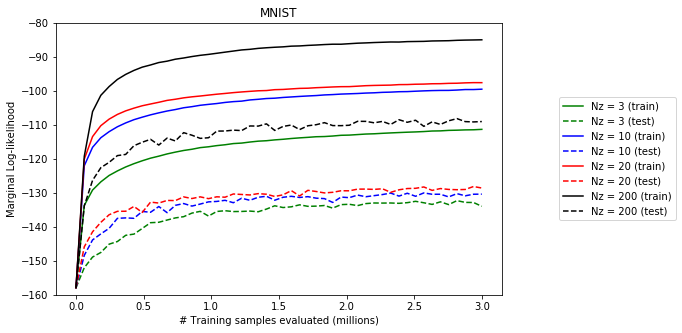

In [85]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()

ax.plot(x, train_elbo_nz3, '-g')
ax.plot(x, test_elbo_nz3, '--g')
ax.plot(x, train_elbo_nz10, '-b')
ax.plot(x, test_elbo_nz10, '--b')
ax.plot(x, train_elbo_nz20, '-r')
ax.plot(x, test_elbo_nz20, '--r')
ax.plot(x, train_elbo_nz200, '-k')
ax.plot(x, test_elbo_nz200, '--k')
ax.set(ylim=(-160, -80), xlabel="# Training samples evaluated (millions)",
      ylabel="Marginal Log-likelihood",
      title="MNIST")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(('Nz = 3 (train)','Nz = 3 (test)','Nz = 10 (train)','Nz = 10 (test)',
           'Nz = 20 (train)','Nz = 20 (test)', 
          'Nz = 200 (train)','Nz = 200 (test)'), loc='center right', bbox_to_anchor=(1.4, 0.5))
pass

In [89]:
rbm_elbo_10000 = np.array([-246.46, -215.65, -205.81, -201.37, -198.75, -197.00, -195.67, -194.84, -194.04, -193.43, -192.79, -192.24, -191.53, -190.94, -190.28, -189.54, -188.61, -187.68, -186.46, -185.10, -183.66, -182.12, -180.44, -178.76, -177.19, -175.50, -174.10, -172.73, -171.55, -170.20, -169.03, -167.67, -166.50, -165.24,  -164.06, -162.92, -161.66, -160.57, -159.60, -158.45, -157.59, -156.63, -155.69, -154.68, -153.67, -152.82, -151.88, -150.76,-149.94, -148.97
])

In [95]:
test_rbm_elbo_10000 = -20 + np.array([-248.22, -216.43, -207.35, -202.91, -200.28, -198.60, -197.34, -196.38, -195.61, -195.04, -194.55, -193.88, -193.26, -192.77, -192.02, -191.34, -190.53, -189.60, -188.50, -187.33, -185.82, -184.30, -182.72, -180.95, -179.29, -177.60, -176.04, -174.55, -173.11, -171.73, -170.55, -169.24, -168.04, -166.72, -165.64, -164.45, -163.13, -161.94, -160.89, -159.83, -158.86, -157.84, -156.87, -155.76, -154.81, -153.93, -153.00, -152.09, -151.32, -150.62])

In [106]:
train_vae_10000 = np.load('train_elbo.npy') * (-1.)
test_vae_10000 = np.load('test_elbo.npy') * (-1.)
test_vae_10000 += (np.min(train_vae_10000) - np.min(test_vae_10000))

rbm_elbo_10000 += (np.min(train_vae_10000) - np.min(rbm_elbo_10000))
test_rbm_elbo_10000 += (np.min(rbm_elbo_10000) - np.min(test_rbm_elbo_10000)) -20

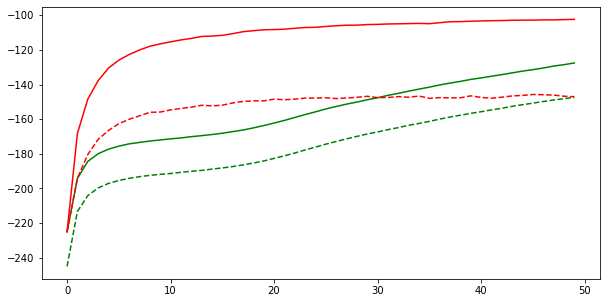

In [107]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()

ax.plot(rbm_elbo_10000, '-g')
ax.plot(test_rbm_elbo_10000, '--g')
ax.plot(train_vae_10000, '-r')
ax.plot(test_vae_10000, '--r')

In [110]:
rbm_elbo_60000 = np.array([-197.50, -193.10, -189.22, -181.53, -172.37, -164.84, -158.62, -152.94, -148.38, -144.63, -141.27, -138.34, -135.73, -133.90, -132.04, -129.99, -128.21, -126.39, -124.73, -123.14, -121.70, -120.34, -118.97, -117.77, -116.48, -115.46, -114.37, -113.26, -112.33, -111.23, -110.48, -109.55, -108.73, -107.99, -107.00, -106.26, -105.55, -104.93, -104.09, -103.43, -102.85, -102.21, -101.71, -101.10, -100.51, -100.03, -99.56, -99.08, -98.56, -98.14])

In [111]:
train_vae_60000 = train_elbo_nz20
test_vae_60000 = test_elbo_nz20
#test_vae_60000 += (np.min(train_vae_60000) - np.min(test_vae_60000))

#rbm_elbo_60000 += (np.min(train_vae_60000) - np.min(rbm_elbo_60000))
#test_rbm_elbo_60000 += (np.min(rbm_elbo_10000) - np.min(test_rbm_elbo_10000)) -20

[(-160, -80)]

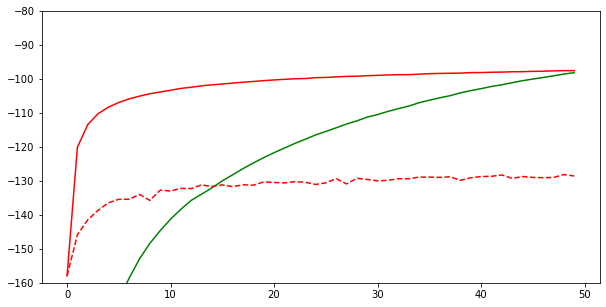

In [116]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()

ax.plot(rbm_elbo_60000, '-g')
#ax.plot(test_rbm_elbo_60000, '--g')
ax.plot(train_vae_60000, '-r')
ax.plot(test_vae_60000, '--r')
ax.set(ylim = (-160, -80))

In [122]:
train_rbm_1000 = np.array([-434.72, -375.29, -337.01, -310.23, -290.79, -276.53, -266.10, -257.98, -251.13, -245.16, -239.74, -234.84, -230.76, -226.92, -223.45, -220.72, -218.15, -215.83, -213.66, -211.99, -210.38, -208.85, -207.48, -206.26, -204.91, -203.84, -203.09, -202.23, -201.45, -200.82, -200.26, -199.65, -199.00, -198.42, -197.93, -197.27, -196.87, -196.52, -196.21, -195.93, -195.56, -195.22, -194.88, -194.56, -194.34, -193.88, -193.53, -193.32, -192.97, -192.75, -192.44, -192.23, -191.95, -191.65, -191.43, -191.28, -191.11, -191.12, -190.89, -190.63, -190.47, -190.43, -190.18, -190.08, -190.04, -189.85, -189.46, -189.24, -189.12, -188.95, -188.89, -188.87, -188.72, -188.74, -188.57, -188.41, -188.31, -188.20, -188.12, -188.11, -187.95, -187.90, -187.88, -187.72, -187.72, -187.55, -187.60, -187.59, -187.43, -187.37, -187.18, -187.17, -187.08, -187.00, -186.86, -186.81, -186.70, -186.62, -186.56, -186.48, -186.28, -186.15, -186.09, -185.93, -185.97, -185.90, -185.78, -185.66, -185.66, -185.52, -185.64, -185.56, -185.47, -185.49, -185.37, -185.34, -185.34, -185.30, -185.44, -185.28, -185.29, -185.17, -185.00, -185.04, -185.02, -184.97, -184.78, -184.63, -184.54, -184.50, -184.33, -184.30, -184.19, -184.20, -184.32, -184.31, -184.18, -183.93, -183.82, -183.72, -183.73, -183.74, -183.89, -183.78, -183.66, -183.62, -183.71, -183.41, -183.37, -183.37, -183.37, -183.18, -183.21, -183.00, -182.92, -182.74, -182.81, -182.79, -182.52, -182.40, -182.36, -182.19, -182.10, -182.06, -182.04, -181.98, -181.90, -181.73, -181.72, -181.73, -181.75, -181.61, -181.60, -181.54, -181.51, -181.58, -181.51, -181.39, -181.33, -181.14, -181.03, -180.98, -180.79, -180.62, -180.59, -180.33, -180.15, -179.95, -179.97, -179.89, -179.72, -179.68, -179.54, -179.43, -179.26, -179.24, -179.07, -178.84, -178.84, -178.81])

In [118]:
train_vae_1000 = np.load('train_elbo.npy') * (-1.)
test_vae_1000 = np.load('test_elbo.npy') * (-1.)

In [172]:
train_bbn_1000 = np.load('BNN_elbo_1000.npy') * (-1.)

In [180]:
train_bbn_1000[np.isnan(train_bbn_1000)] = np.random.normal(np.max(train_bbn_1000[~np.isnan(train_bbn_1000)]), 
                                                            0.5, 
                                                           len(train_bbn_1000[np.isnan(train_bbn_1000)]))

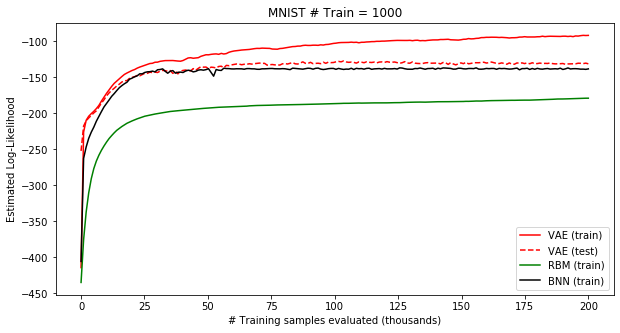

In [242]:
x_1000 = np.linspace(0, 200, 200)
fig = plt.figure(figsize=(10,5))
ax = plt.axes()

ax.plot(x_1000, train_vae_1000, '-r')
ax.plot(x_1000, test_vae_1000, '--r')
ax.plot(x_1000, train_rbm_1000, '-g')
ax.plot(x_1000, train_bbn_1000, '-k')
ax.legend(("VAE (train)","VAE (test)", "RBM (train)", "BNN (train)"))
ax.set(title = "MNIST # Train = 1000",
       xlabel = "# Training samples evaluated (thousands)",
      ylabel = "Estimated Log-Likelihood")
pass

In [218]:
train_rbm_full = np.array([-197.50, -193.10, -189.22, -181.53, -172.37, -164.84, -158.62, -152.94, -148.38, -144.63, -141.27, -138.34, -135.73, -133.90, -132.04, -129.99, -128.21, -126.39, -124.73, -123.14, -121.70, -120.34, -118.97, -117.77, -116.48, -115.46, -114.37, -113.26, -112.33, -111.23, -110.48, -109.55, -108.73, -107.99, -107.00, -106.26, -105.55, -104.93, -104.09, -103.43, -102.85, -102.21, -101.71, -101.10, -100.51, -100.03, -99.56, -99.08, -98.56, -98.14, -97.71, -97.27, -96.76, -96.44, -96.00, -95.51, -95.07, -94.71, -94.44, -94.00, -93.58, -93.19, -92.90, -92.54, -92.22, -91.81, -91.35, -91.25, -90.73, -90.55, -90.21, -89.88, -89.56, -89.35, -88.94, -88.78, -88.42, -88.14, -87.95, -87.61, -87.36, -87.20, -86.82, -86.66, -86.36, -86.19, -85.97, -85.76, -85.48, -85.29, -85.07, -84.82, -84.58, -84.47, -84.21, -84.02, -83.81, -83.63, -83.53, -83.21, -83.02, -82.87, -82.74, -82.59, -82.38, -82.21, -82.04, -81.84, -81.66, -81.54, -81.35, -81.26, -81.08, -80.89, -80.69, -80.55, -80.55, -80.25, -80.17, -80.03, -79.88, -79.67, -79.70, -79.58, -79.41, -79.27, -79.14, -79.00, -78.88, -78.72, -78.59, -78.41, -78.40, -78.21, -78.10, -78.06, -77.86, -77.72, -77.68, -77.46, -77.50, -77.31, -77.17, -77.08, -77.07, -76.95, -76.81, -76.80, -76.62, -76.49, -76.51, -76.28, -76.15, -76.04, -76.06, -75.90, -75.83, -75.69, -75.66, -75.52, -75.47, -75.39, -75.26, -75.23, -75.13, -75.03, -74.95, -74.86, -74.79, -74.74, -74.63, -74.55, -74.58, -74.33, -74.26, -74.27, -74.18, -73.88, -73.97, -73.85, -73.97, -73.88, -73.63, -73.61, -73.55, -73.34, -73.46, -73.44, -73.20, -73.19, -73.09, -73.01, -72.89, -72.95, -72.80, -72.61, -72.61, -72.59, -72.63, -72.42])

In [231]:
train_vae_full = np.load('train_elbo.npy') * (-1.)
test_vae_full = np.load('test_elbo.npy') * (-1.)

In [233]:
train_bbn_full = np.load('BNN_elbo.npy') * (-1.) + 40.

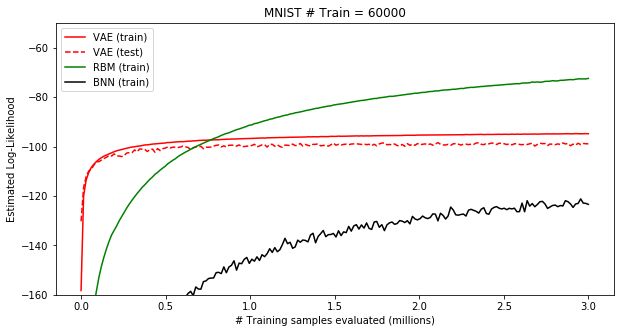

In [244]:
x_full = np.linspace(0, 3, 200)
fig = plt.figure(figsize=(10,5))
ax = plt.axes()

ax.plot(x_full, train_vae_full, '-r')
ax.plot(x_full, test_vae_full, '--r')
ax.plot(x_full, train_rbm_full, '-g')
ax.plot(x_full, train_bbn_full, '-k')
ax.legend(("VAE (train)","VAE (test)", "RBM (train)", "BNN (train)"))
ax.set(ylim = (-160, -50), title = "MNIST # Train = 60000",
       xlabel = "# Training samples evaluated (millions)",
      ylabel = "Estimated Log-Likelihood")
pass